In [2]:
%load_ext autoreload
%autoreload 2

In [141]:
sentences = []
stereotypes = []

for line in open('./data/samples.txt'):
    words = line.split()
    sentences.append(' '.join(words[:-1]))
    stereotypes.append(int(words[-1]))

stereo_names = """
Emotional
Gentle
Empathetic
Neat
Social
Weak
Beautiful
Tough
Self-confident
Professional
Rational
Providers
Leaders
Childish
Sexual
Strong
""".strip().split('\n')
stereo_names = [
    f'{name} #{i+1}'
    for i, name in enumerate(stereo_names)
]

In [4]:
from collections import Counter
import math
import random
import statistics

import matplotlib.pyplot as plt
from unidecode import unidecode
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer

from masked_models.utils import calculate_logprob, tokenize, model_init

import matplotlib.pyplot as plt
from functools import lru_cache
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

def bootstrap_ci(scores, alpha=0.95):
    """
    Bootstrapping based estimate.
    
    Return mean and confidence interval (lower and upper bound)
    """
    loc, scale = norm.fit(scores)    
    bootstrap = [sum(random.choices(scores, k=len(scores))) / len(scores) for _ in range(1000)]
    lower, upper = norm.interval(alpha, *norm.fit(bootstrap))
        
    return loc, lower, upper


def set_size(w,h, ax=None):
    """
    Used to size the figures with subplots
    
    https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units
    """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


In [6]:



templates = [
    (lambda s: f'He said: "{s}"', lambda s: f'She said: "{s}"'),
    (lambda s: f'The man said: "{s}"', lambda s: f'The woman said: "{s}"'),
    (lambda s: f'"{s}", he said.', lambda s: f'"{s}", she said.'),
    (lambda s: f'"{s}", the man said.', lambda s: f'"{s}", the woman said.'),
]

models = [
    'bert-base-uncased',
    'roberta-base',    
    'albert-base-v2',
    'bert-base-multilingual-cased',
    'xlm-roberta-base',
    'xlm-roberta-large',
    'facebook/xlm-v-base',
    'facebook/xlm-roberta-xl',
    'distilbert-base-uncased',
    'google/electra-large-generator',
    'google/electra-base-generator',
]

def short_model_name(model):
    for s in ('uncased', 'v2', 'cased', 'generator'):
        if model.endswith('-' + s):
            model = model[:-len(s)-1]
    model = model.split('/')[-1]
    if model.endswith('lingual'):
        model = model[:-7]
    return model

In [84]:
@lru_cache
def model_results(filename):
    return list(map(float, open(filename, 'r').read().split('\n')))

@lru_cache
def model_results_standard(model_handle, template_id):
    model_handle = model_handle.split('/')[-1]
    filename = f'./cache/predictions/standard/{model_handle}_template-{template_id}.txt'
    return model_results(filename)

def stereotype_results(model_results, stereotype_id):
    return [
        res
        for res, ste in zip(model_results, stereotypes)
        if ste == stereotype_id
    ]

def all_stereotypes_results(model_results):
    return [
        stereotype_masculine_rate(model_results, stereotype_id)[0]
        for stereotype_id in range(1, 17)
    ]

def all_stereotypes_ranks(model_results):
    rates = all_stereotypes_results(model_results)
    return np.argsort(np.argsort(rates)) + 1

def stereotype_masculine_rate(model_results, stereotype_id):
    return bootstrap_ci(stereotype_results(model_results, stereotype_id))

def r_f(results):
    return np.mean([
        stereotype_masculine_rate(results, i)[0]
        for i in range(1, 8)
    ]) 

def r_m(results):
    return np.mean([
        stereotype_masculine_rate(results, i)[0]
        for i in range(8, 17)
    ]) 

def masculine_rate(results):
    return (r_m(results) + r_f(results)) / 2

def stereotype_rate(results):
    return r_m(results) - r_f(results)

def visualize_corr(corr):
    plt.colorbar(plt.imshow(corr, vmin=0, vmax=1))
    plt.show()

len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
len 166
0.10356665294061326 -0.03769059379283133 -0.06458755152408129


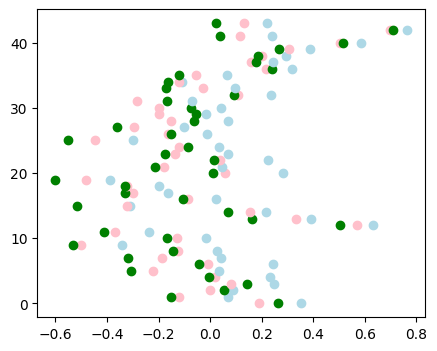

In [155]:
def family_rate(results):
    family_words = 'family child children partner kids kid family\'s'.split()
    d = [
        res
        for res, sen, ste in zip(results, sentences, stereotypes)
        if any(word in sen for word in family_words) and ste > 7
    ]
    print('len', len(d))
    return np.mean(d)

al, bl, cl = [], [], []
for i, (model_handle, template_id) in enumerate(product(models, range(4))):
    results = model_results_standard(model_handle, template_id)
    a, b, c = r_m(results), r_f(results), family_rate(results)
    plt.scatter([a], [i], c='lightblue')
    plt.scatter([b], [i], c='pink')
    plt.scatter([c], [i], c='green')
    al.append(a); bl.append(b); cl.append(c)
print(np.mean(al), np.mean(bl), np.mean(cl))


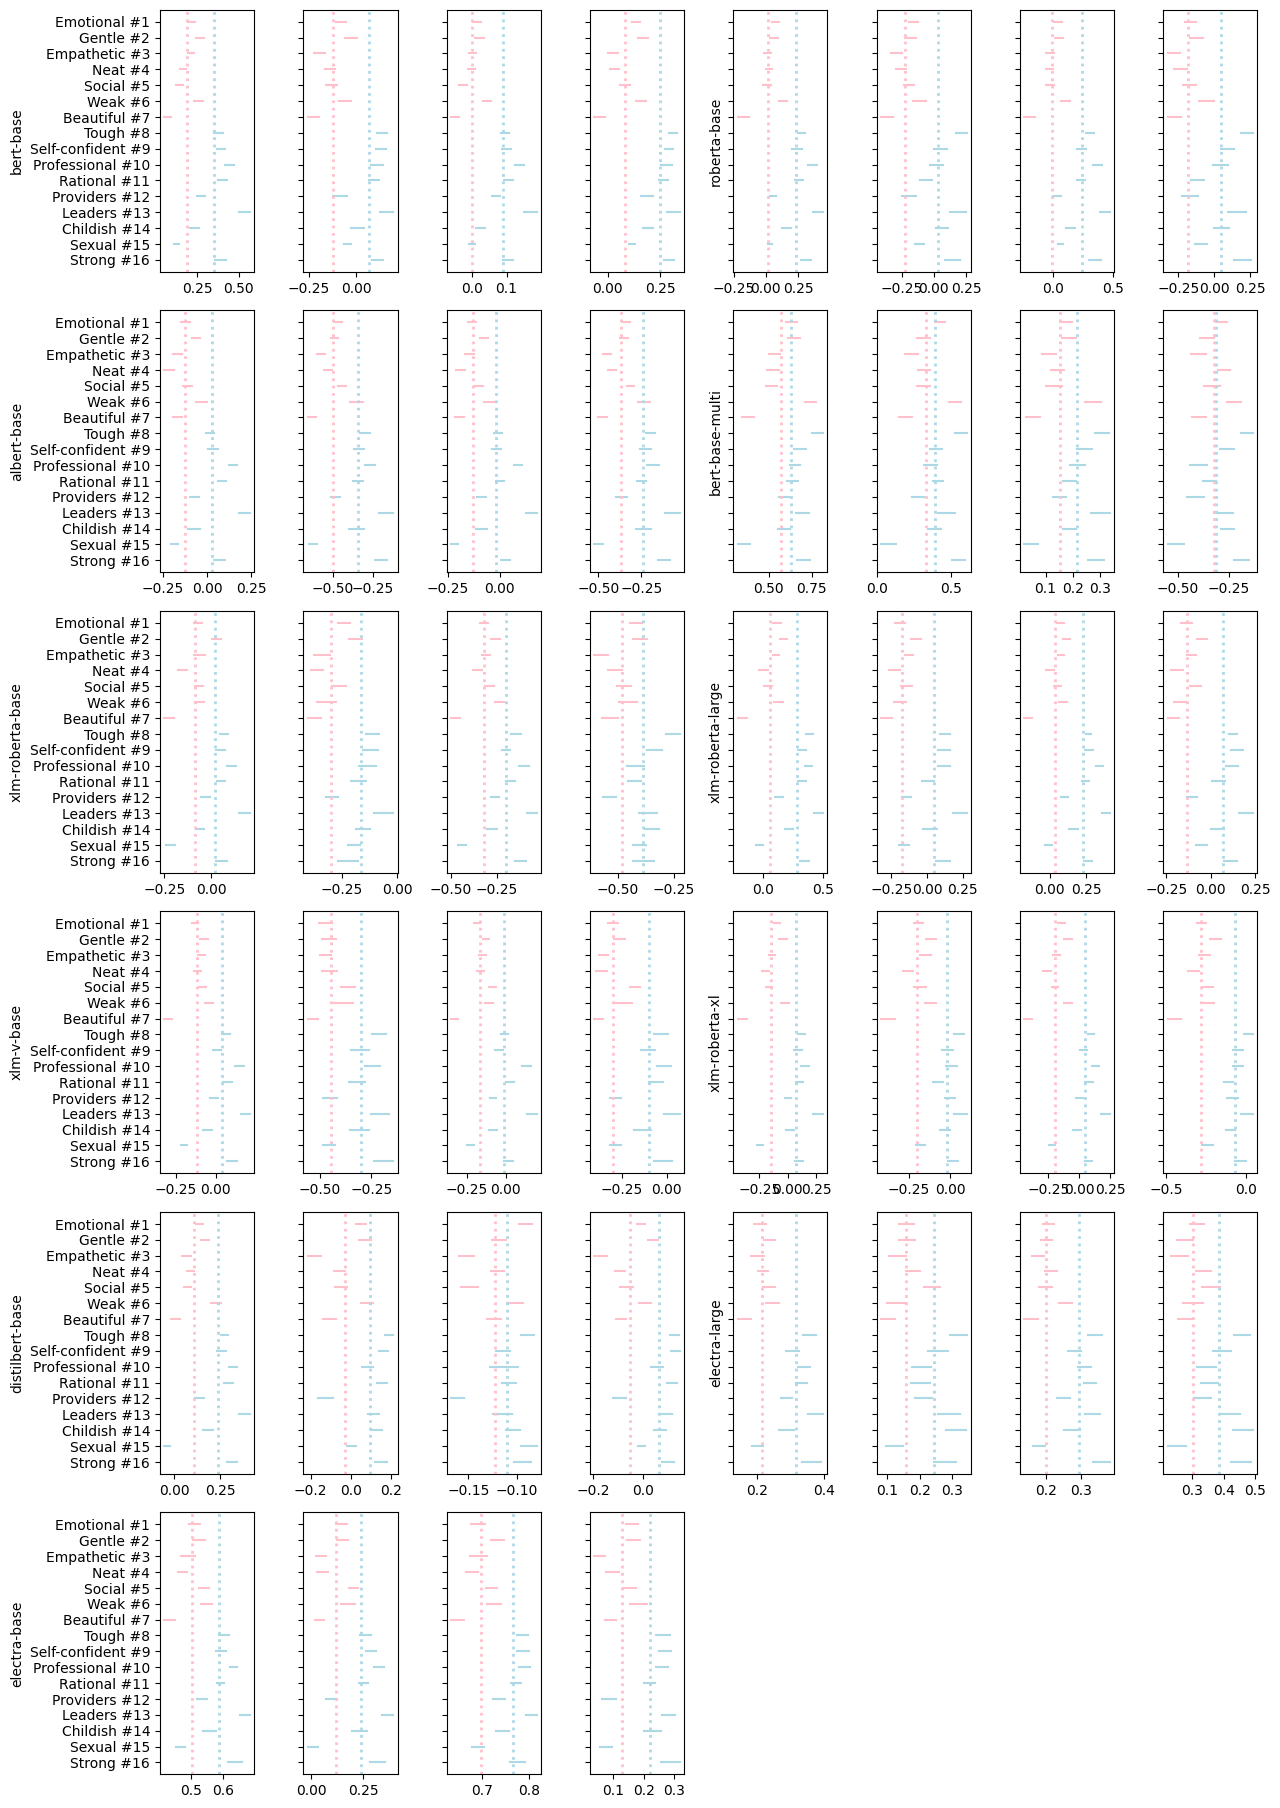

In [142]:
from itertools import product

fig, axes = plt.subplots(6, 8, sharey=True)
axes = axes.reshape(-1)
axes[0].invert_yaxis()

for ax in axes[-4:]:
    ax.remove()

for ax, (model_handle, template_id) in zip(axes, product(models, range(4))):
    results = model_results_standard(model_handle, template_id)
    for stereotype in range(1, 17):
        _, lower, upper = stereotype_masculine_rate(results, stereotype)
        ax.plot([lower, upper], [stereotype, stereotype], c=('pink' if stereotype < 8 else 'lightblue'))
    ax.set_yticks(range(1, 17), stereo_names)
    ax.axvline(r_m(results), linestyle=':', linewidth=2, color='lightblue')
    ax.axvline(r_f(results), linestyle=':', linewidth=2, color='pink')
        
    if template_id == 0:
        ax.set_ylabel(short_model_name(model_handle))

set_size(10, 14)
plt.tight_layout()
# plt.show()
plt.savefig('./figures/en_all.pdf')

In [140]:
def format_ci(mean, lower, upper):
    return f'{lower:.2f} {mean:.2f} {upper:.2f}'

for model in models:
    print('\\midrule')
    print("& \multicolumn{16}{l}{\\texttt{", end='')
    print(short_model_name(model), end='')
    print("}} \\\\")
    for template in range(4):
        print(template+1, *[
            format_ci(*stereotype_masculine_rate(model_results_standard(model, template), stereotype))
            for stereotype in range(1, 17)
        ], sep=' & ', end=' \\\\\n')

\midrule\\
\multicolumn{17}{l}{\texttt{bert-base}} \
1 & 0.20 0.22 0.24 & 0.24 0.27 0.29 & 0.19 0.21 0.23 & 0.15 0.17 0.18 & 0.12 0.14 0.16 & 0.23 0.26 0.28 & 0.05 0.07 0.09 & 0.35 0.38 0.40 & 0.37 0.39 0.42 & 0.42 0.44 0.47 & 0.37 0.40 0.43 & 0.25 0.27 0.29 & 0.50 0.53 0.57 & 0.21 0.23 0.26 & 0.11 0.13 0.14 & 0.36 0.39 0.42 \\
2 & -0.11 -0.08 -0.05 & -0.06 -0.03 0.00 & -0.22 -0.19 -0.16 & -0.16 -0.14 -0.11 & -0.16 -0.13 -0.10 & -0.09 -0.06 -0.03 & -0.26 -0.23 -0.20 & 0.11 0.14 0.16 & 0.10 0.13 0.16 & 0.08 0.11 0.14 & 0.07 0.09 0.12 & -0.13 -0.09 -0.05 & 0.12 0.16 0.20 & -0.02 0.01 0.04 & -0.06 -0.05 -0.03 & 0.08 0.11 0.14 \\
3 & 0.00 0.01 0.03 & 0.01 0.02 0.04 & -0.01 0.00 0.01 & -0.01 -0.00 0.01 & -0.04 -0.03 -0.02 & 0.03 0.04 0.05 & -0.06 -0.05 -0.04 & 0.09 0.10 0.11 & 0.09 0.10 0.11 & 0.13 0.14 0.15 & 0.09 0.11 0.12 & 0.06 0.07 0.08 & 0.15 0.17 0.19 & 0.01 0.02 0.04 & -0.01 -0.00 0.01 & 0.09 0.10 0.12 \\
4 & 0.12 0.14 0.15 & 0.14 0.17 0.19 & -0.00 0.02 0.05 & 0.01 0.03 0.05 & 0.06 

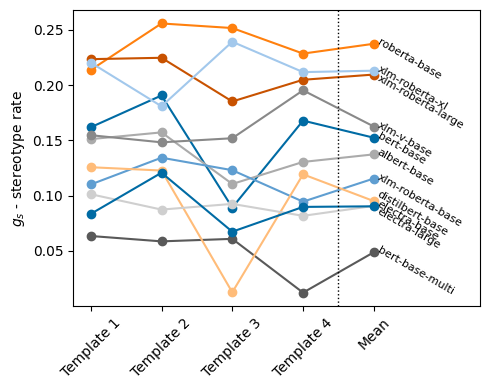

In [41]:
plt.rcParams["figure.figsize"] = (5,4)
plt.style.use('tableau-colorblind10')

for model in models:
    rates = [
        stereotype_rate(model_results_standard(model, template_id))
        for template_id in range(4)
    ]
    plt.plot(range(1,6), rates + [np.mean(rates)], marker='o')
    model_name = short_model_name(model)
    ver_offset = {'distilbert-base': 0.005, 'xlm-roberta-large': -0.005, 'electra-large': -0.007}.get(model_name, 0)
    plt.text(5 + 0.04, np.mean(rates) + ver_offset, model_name, fontsize=8, rotation=-30, rotation_mode='anchor')
plt.axvline(4.5, linestyle=':', linewidth=1, color='black')
plt.xticks(range(1, 6), [f'Template {i}' for i in range(1, 5)] + ['Mean'], rotation=45)
plt.xlim(0.75, 6.5)
plt.ylabel('$g_s$ - stereotype rate')
plt.tight_layout()
plt.savefig('./figures/en_templates.pdf')

/tmp/ipykernel_44/704862206.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  results = np.vstack(


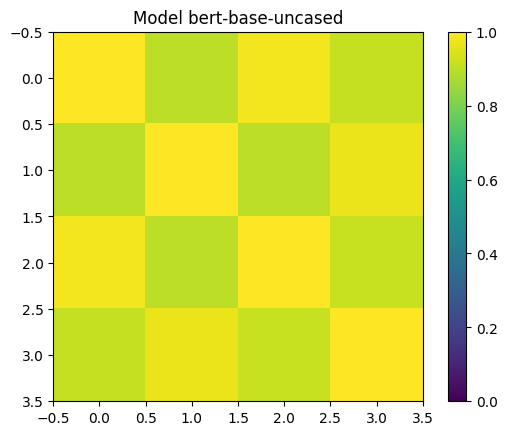

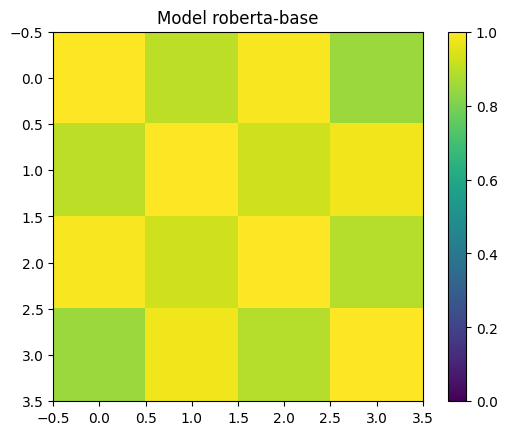

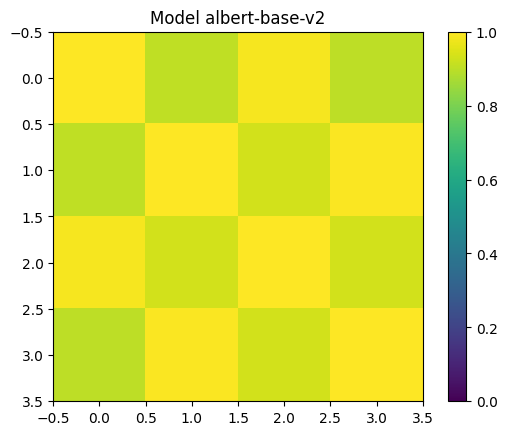

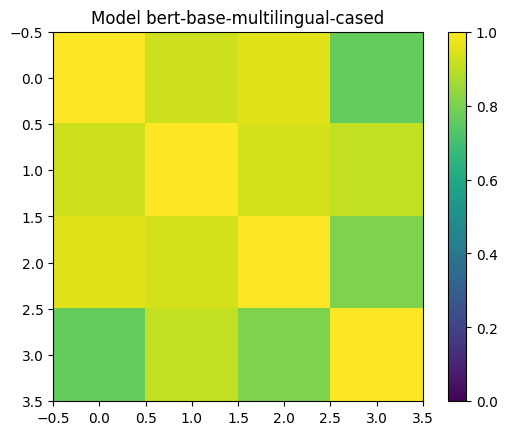

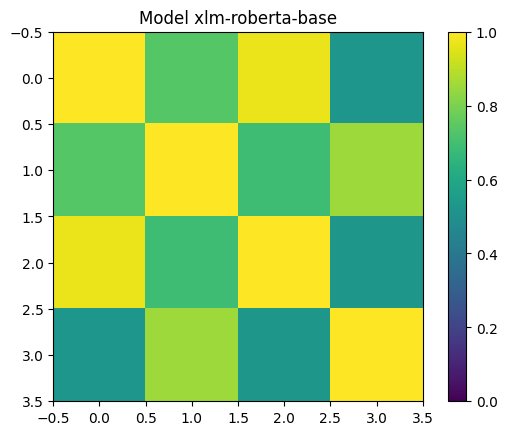

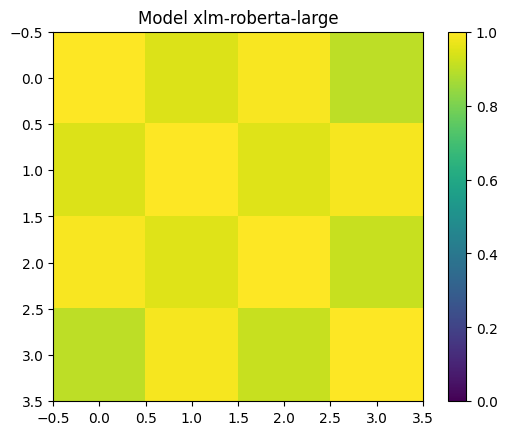

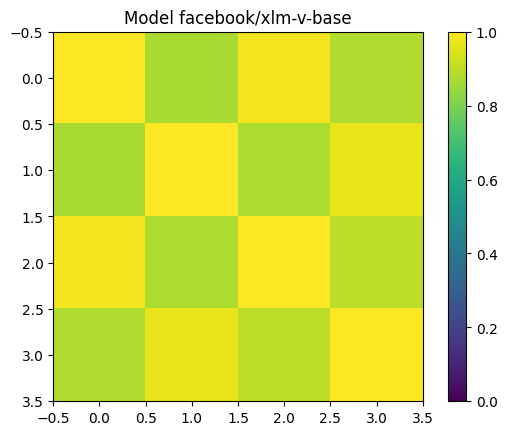

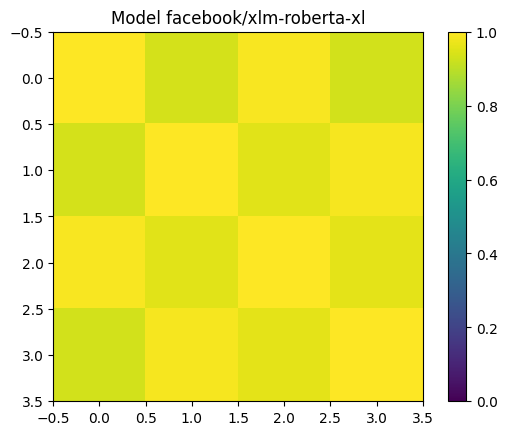

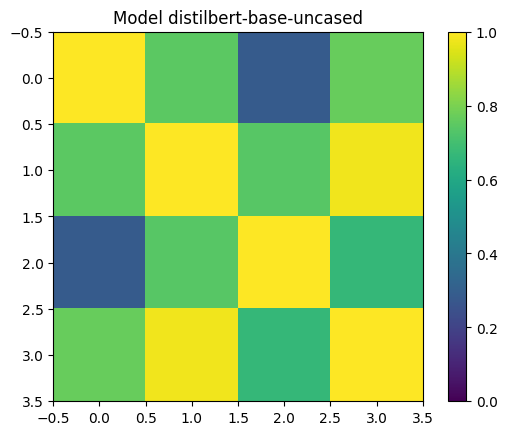

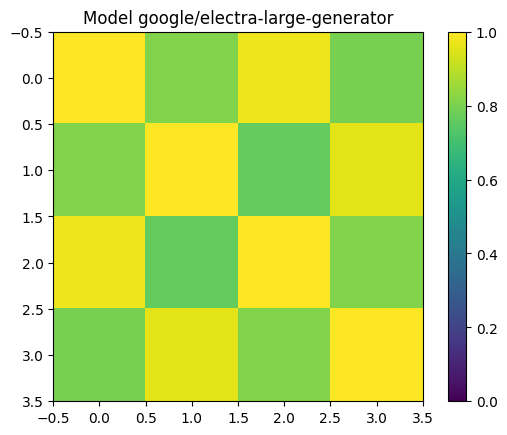

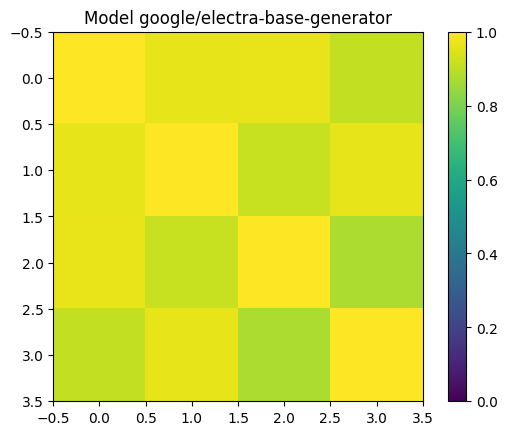

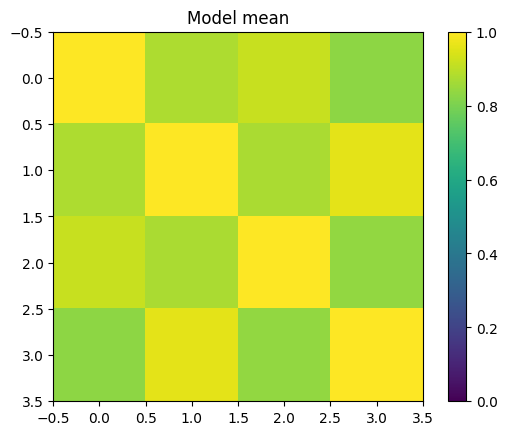

In [44]:
"""
Template correlations.

The correlations are quite strong (0.6+). Correlations between templates that use the same words (X he said, He said X) are much stronger.
This shows certain lexical consistency, that is not the same when we change the gender identifier (he > the man).
"""
corrs = []
for model in models:
    results = np.vstack(
        # model_results_standard(model, template_id)
        all_stereotypes_results(model_results_standard(model, template_id))
        for template_id in range(4)
    )
    corr = np.corrcoef(results)
    corrs.append(corr)
    plt.title(f'Model {model}')
    visualize_corr(corr)

mean_corrs = np.mean( np.array(corrs), axis=0)
plt.title(f'Model mean')
visualize_corr(mean_corrs)

/tmp/ipykernel_41/3768915842.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  results = np.vstack(


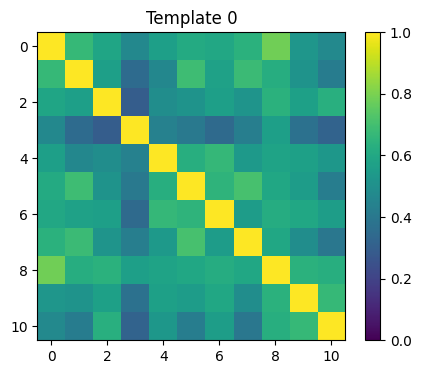

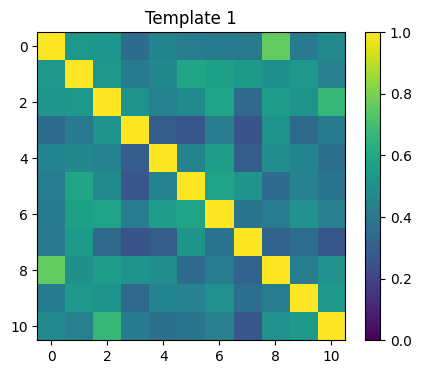

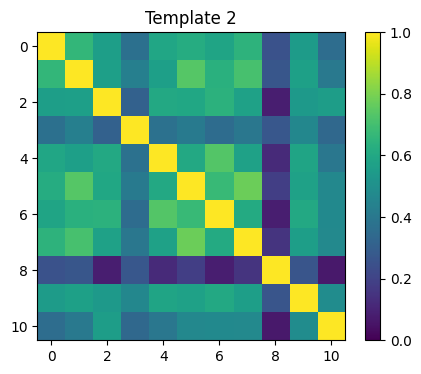

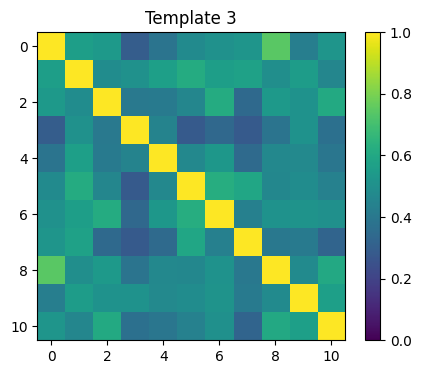

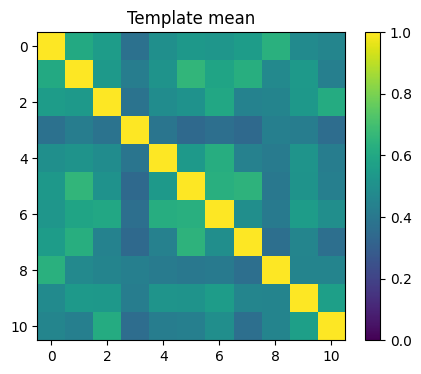

In [47]:
"""
Model correlations.

How the results correlate between models. The correlations are weaker overall (0.5), and they do not say that much.
Only visible pattern is that MBERT is less correlated to the other models.
"""

corrs = []
for template_id in range(4):
    results = np.vstack(
        model_results_standard(model, template_id)
        # all_stereotypes_results(model_results_standard(model, template_id))
        for model in models
        if model != 2
    )
    corr = np.corrcoef(results)
    plt.title(f'Template {template_id}')
    visualize_corr(corr)
    corrs.append(corr)

mean_corr = np.mean(np.array(corrs), axis=0)
plt.title(f'Template mean')
visualize_corr(mean_corr)

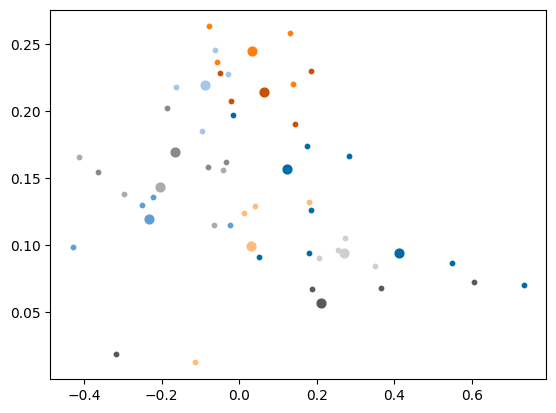

In [16]:
import matplotlib.colors as mcolors
plt.style.use('tableau-colorblind10')
for i, model in enumerate(models):
    ms_buf = []
    ss_buf = []
    for template_id in range(4):
        results = model_results_standard(model, template_id)
        ms, ss = masculine_rate(results), stereotype_rate(results)
        plt.scatter([ms], [ss], c=f'C{i % 10}', s=10, label=model if template_id == 0 else None)
        ms_buf.append(ms)
        ss_buf.append(ss)

    plt.scatter([np.mean(ms_buf)], [np.mean(ss_buf)], c=f'C{i % 10}', s=40)
# plt.legend()

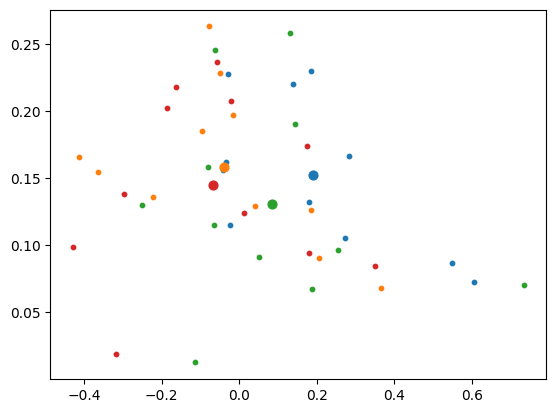

In [11]:
"""
There are some differences between he/she and man/woman prompts in the masculine rate
=> The base rate is different for different prompts
=> But the stereotype rate seems to hold (the big points are means for templates)
"""
import matplotlib.colors as mcolors

for template_id in range(4):
    ms_buf = []
    ss_buf = []
    for model in models:
        results = model_results_standard(model, template_id)
        ms, ss = masculine_rate(results), stereotype_rate(results)
        plt.scatter([ms], [ss], c=list(mcolors.TABLEAU_COLORS)[template_id], s=10)
        ms_buf.append(ms)
        ss_buf.append(ss)

    plt.scatter([np.mean(ms_buf)], [np.mean(ss_buf)], c=list(mcolors.TABLEAU_COLORS)[template_id], s=40)

In [12]:
"""
The CIs for the masculine rate are pretty narrow. The diffs in the points are not just noise.
=> The models behave differently for different prompts
"""
for model in models:
    print(bootstrap_ci(model_results_standard(model, 0)))

(0.2824986580356976, 0.2755224827784305, 0.28971522767128766)
(0.13826085566471202, 0.12833613274616854, 0.1484976718978759)
(-0.040539377033292495, -0.047905058818709004, -0.03281952219598301)
(0.6049243009901314, 0.5956079687921367, 0.6144065529878839)
(-0.024586912989616395, -0.03164600379122727, -0.017538154778296927)
(0.18540647845574215, 0.17474585053926284, 0.19578808166682193)
(-0.03313888790814773, -0.0405178700661854, -0.02570532714988598)
(-0.027565988407145043, -0.03742649300054646, -0.01757341671303364)
(0.17962525462702983, 0.172267803250496, 0.1865034203115653)
(0.2722682072688286, 0.26709713558882825, 0.2773243644851742)
(0.548861135118138, 0.5441612825726372, 0.5533288211841885)


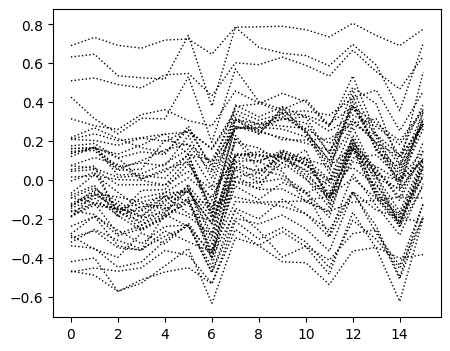

In [73]:
"""
Some (model, template) combinations show either masculine or feminine preference. The stereotypical reasoning is similar in
all of them (the lines are similar), but the base rate (masculine/feminine preference) is different.
"""
sorted_arrs = []
for model, template_id in product(models, range(4)):
    arr = all_stereotypes_results(model_results_standard(model, template_id))
    arr = np.array(arr)
    # arr -= min(arr)
    # arr /= max(arr)
    plt.plot(arr, c='black', linestyle=':', linewidth=1)


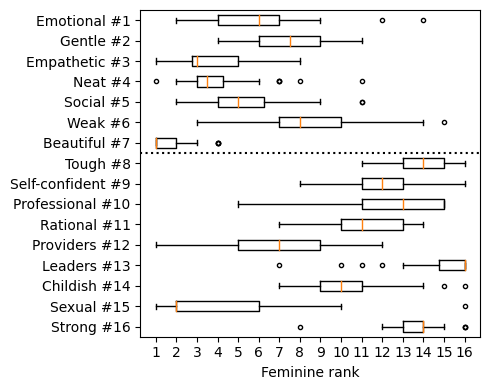

In [143]:
"""
Boxplot of positions (the rank in the list of 16 stereotypes) for all stereotypes.
"""
ranks = np.vstack([
    all_stereotypes_ranks(model_results_standard(model, template))
    for model in models
    for template in range(4)
])
plt.boxplot([ranks[:,i] for i in range(16)], vert=False, sym='.')
plt.axhline(7.5, c='black', linestyle=':')
plt.gca().invert_yaxis()
plt.xticks(range(1,17))
plt.yticks(range(1,17), stereo_names)
plt.xlabel('Feminine rank')
plt.tight_layout()
plt.savefig('./figures/en_ranks.pdf')

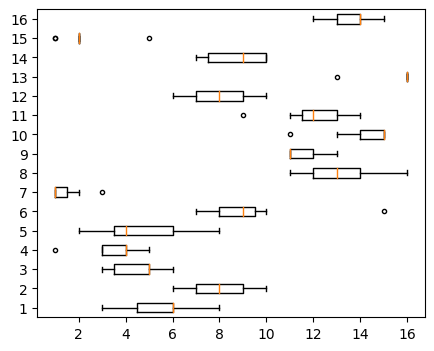

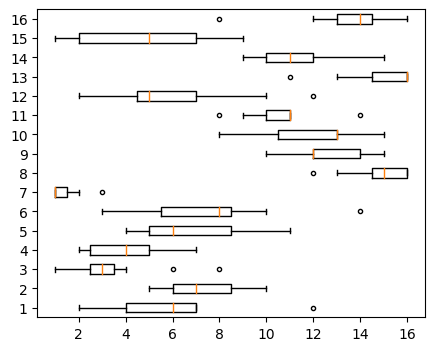

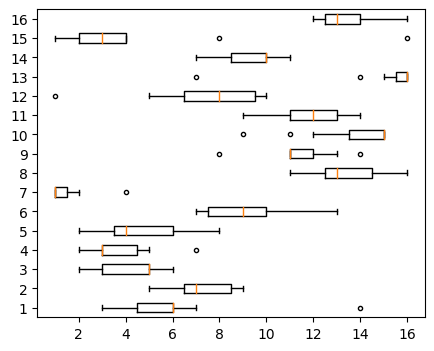

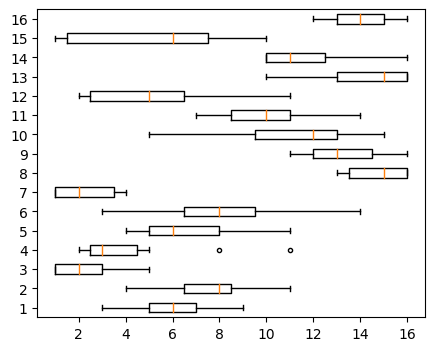

In [42]:
"""
Boxplots for templates
"""
for template_id in range(4):
    sorted_arrs = []
    
    for model in models:
        arr = []
        results = model_results_standard(model, template_id)
        for stereotype in range(1, 17):
            arr.append(np.mean(stereotype_results(results, stereotype)))
        arr = np.array(arr)
        # arr -= min(arr)
        # arr /= max(arr)
        # plt.plot(arr, c='black', linestyle=':', linewidth=1)
        sorted_arrs.append(np.argsort(arr))
    
    positions = np.repeat(np.arange(1,17).reshape(1,16), 11, axis=0)
    plt.boxplot([positions[np.vstack(sorted_arrs) == i] for i in range(16)], vert=False, sym='.');
    plt.show()


# Correlation

In [70]:
from itertools import combinations, product
from scipy.stats import pearsonr

res = {(m, t): model_results_standard(m, t) for m, t in product(models, range(4))}
res_s = {(m,t): all_stereotypes_results(res[m, t]) for m, t in product(models, range(4))}

0.8159441248630586

In [71]:
(
    np.mean([
        np.mean([
            pearsonr(res[model1, template], res[model2, template])[0]
            for model1, model2 in combinations(models, 2)
        ])
        for template in range(4)
    ]),
    
    np.mean([
        np.mean([
            pearsonr(res_s[model1, template], res_s[model2, template])[0]
            for model1, model2 in combinations(models, 2)
        ])
        for template in range(4)
    ])
)

(0.48817286899183115, 0.8159441248630586)

In [72]:
(
    np.mean([
        np.mean([
            pearsonr(res[model, template1], res[model, template2])[0]
            for template1, template2 in combinations(range(4), 2)
        ])
        for model in models
    ]),
    
    np.mean([
        np.mean([
            pearsonr(res_s[model, template1], res_s[model, template2])[0]
            for template1, template2 in combinations(range(4), 2)
        ])
        for model in models
    ])
)

(0.7191824940655134, 0.8817579292755547)

# MultiBERT

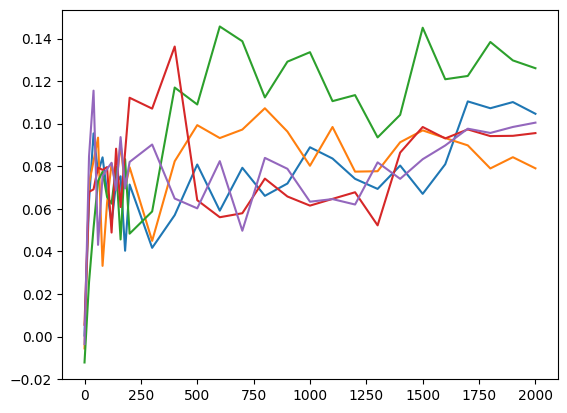

In [32]:
import glob
import re

pred_files = glob.glob('./cache/predictions/multibert/*seed_0*')
steps = sorted(set(
    int(re.findall(r'([0-9]+)k', filename)[0])
    for filename in pred_files
    if 'k' in filename
))

def multibert_results(seed_id, step_count, template_id):
    filename = f'./cache/predictions/multibert/multiberts-seed_{seed_id}-step_{step_count}k_template-{template_id}.txt'
    return model_results(filename)

def multibert_results_final(seed_id, template_id):
    filename = f'./cache/predictions/multibert/multiberts-seed_{seed_id}_template-{template_id}.txt'
    return model_results(filename)

# plt.plot(
#     steps,
#     [
#         masculine_rate(multibert_results(step, 0))
#         for step in steps
#     ]
# )
for seed_id in range(5):
    plt.plot(
        steps,
        [
            stereotype_rate(multibert_results(seed_id, step, 3))
            for step in steps
        ]
    )

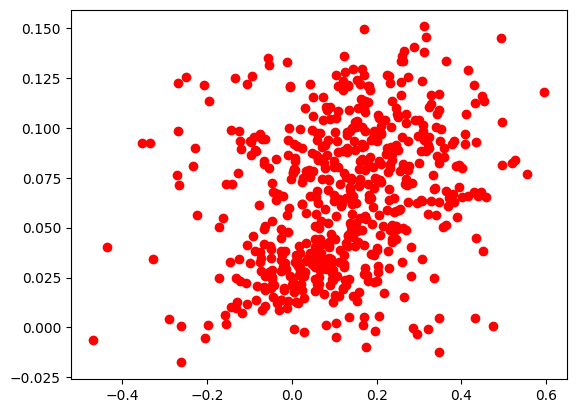

In [26]:
for seed_id in range(5):
    for template_id in range(4):
        for step in steps:
            results = multibert_results(seed_id, step, template_id)
            plt.scatter([masculine_rate(results)], [stereotype_rate(results)], c='r')

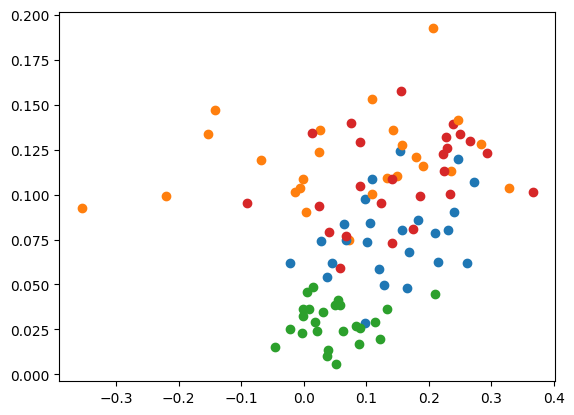

In [38]:
import matplotlib.colors as mcolors

for seed_id in range(25):
    for template_id in range(4):
        results = multibert_results_final(seed_id, template_id)
        plt.scatter([masculine_rate(results)], [stereotype_rate(results)], c=list(mcolors.TABLEAU_COLORS)[template_id])

/tmp/ipykernel_2965/1143751287.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  results = np.vstack(


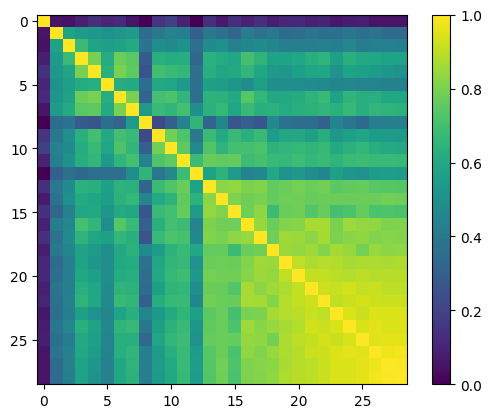

In [28]:
results = np.vstack(
    multibert_results(4, step, 0)
    for step in steps
)
corr = np.corrcoef(results)
visualize_corr(corr)

# Make predictions

In [11]:
def english_mlm_score(sample, templates, model, tokenizer, device):
    sen1, sen2 = templates[0](sample), templates[1](sample)
    a = calculate_logprob(sen1, sen2, tokenizer, model, device=device)
    b = calculate_logprob(sen2, sen1, tokenizer, model, device=device)
    return a - b

def make_predictions(model_handle, samples, templates, device):
    model, tokenizer = model_init(model_handle)
    return [
        english_mlm_score(sample, templates, model, tokenizer, device)
        for sample in tqdm(samples)
    ]

models = [
    'distilbert-base-uncased',
    'google/electra-large-generator',
    'google/electra-base-generator',
]

for model_handle in models:
    for i, template in enumerate(templates):
        preds = make_predictions(model_handle, sentences, template, 'cuda:0')
        import os
        os.makedirs('./cache/predictions/standard', exist_ok=True)
        with open(f'./cache/predictions/standard/{model_handle.split("/")[-1]}_template-{i}.txt', 'w') as f:
            f.write('\n'.join(map(str, preds)))

100%|███████████████████████████████████████████████████████████████████████████████| 3565/3565 [01:06<00:00, 53.49it/s]


In [ ]:
import requests

url = "https://huggingface.co/api/models"
payload = {"search": "google/multiberts"}
response = requests.get(url, params=payload)
handles = [
    hit['id']
    for hit in response.json()
]
handles

import os

for handle in handles[5:]:
    for t_id, template in enumerate(templates):
        preds = make_predictions(handle, sentences, template, 'cuda:0')
        dir_name = handle.split('/')[1]
        os.makedirs('./cache/predictions/multibert', exist_ok=True)
        with open(f'./cache/predictions/multibert/{dir_name}_template-{t_id}.txt', 'w') as f:
            f.write('\n'.join(map(str, preds)))